In [1]:

import numpy as np

from pathlib import Path
import os
from natsort import natsorted
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *
from paths import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
protein = 'abl'
study_name = 'markov_lag'
data_path = Path(f'data_{protein}/msm/{study_name}')
save_dir = Path(f'data_{protein}/plots/')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

In [6]:
n_score = 5 # The number of timescales to plot
columns = [f't{i+2}' for i in range(n_score)] \
        + [f'gap_{i+2}' for i in range(n_score)] \
        + [f'vamp2eq_{i+2}' for i in range(n_score)]
markov_lags = np.array(hps['markov__lag'].to_list())/20

In [7]:
summary = raw.replace([np.inf, -np.inf], np.nan)
summary.dropna(inplace=True)
summary_groupby = summary.groupby('hp_id')[columns].agg(['mean', 'std'])
summary_groupby

t2                          t3                          t4  \
               mean           std          mean           std          mean   
hp_id                                                                         
0      5.562448e+04  1.767660e+05  7.554339e+03  3.541227e+03  3.867235e+03   
1      2.889772e+05  8.852167e+05  3.336726e+04  1.745486e+04  1.619173e+04   
2      2.293259e+05  3.213123e+05  6.428803e+04  3.798292e+04  3.112479e+04   
3      1.094343e+06  1.694222e+06  2.704751e+05  1.545767e+05  1.147420e+05   
4      2.453539e+06  3.978463e+06  5.434787e+05  3.317698e+05  2.087903e+05   
5      2.799372e+07  8.709573e+07  2.937828e+06  2.215963e+06  1.070987e+06   
6      1.915227e+07  2.499632e+07  5.463393e+06  3.641442e+06  2.023345e+06   

                                t5                            t6  \
                std           mean            std           mean   
hp_id                                                              
0      1.746145e+03    1373.464629    1078.256589     463.915892   
1      7.799384e+03    5308.615979    4277.866085    1795.705895   
2      1.556632e+04   10203.289661    9350.223532    3154.353131   
3      5.734411e+04   36946.767151   38602.615298   10285.291531   
4      1.183523e+05   59504.674742   64419.126492   17444.171632   
5      6.435048e+05  291912.376020  298390.426879   81408.273666   
6      1.040817e+06  613622.886595  684700.130078  168847.490707   

                      ... vamp2eq_2           vamp2eq_3           vamp2eq_4  \
                 std  ...      mean       std      mean       std      mean   
hp_id                 ...                                                     
0         314.035912  ...  1.999801  0.000163  2.999469  0.000326  3.998771   
1        1221.725876  ...  1.999784  0.000186  2.999386  0.000408  3.998526   
2        2172.342145  ...  1.999780  0.000165  2.999368  0.000381  3.998445   
3        6876.553860  ...  1.999718  0.000252  2.999183  0.000623  3.997910   
4       11479.464935  ...  1.999720  0.000281  2.999158  0.000705  3.997726   
5       53898.758648  ...  1.999736  0.000231  2.999185  0.000615  3.997743   
6      111038.425096  ...  1.999712  0.000282  2.999129  0.000725  3.997675   

                vamp2eq_5           vamp2eq_6            
            std      mean       std      mean       std  
hp_id                                                    
0      0.000823  4.996706  0.001797  5.990826  0.004268  
1      0.001056  4.995829  0.002343  5.988221  0.005582  
2      0.001078  4.995415  0.002742  5.986586  0.007006  
3      0.001721  4.993426  0.004058  5.980161  0.010429  
4      0.001955  4.992334  0.004771  5.976786  0.012373  
5      0.001907  4.991952  0.005262  5.975149  0.014022  
6      0.002012  4.992114  0.004772  5.976103  0.012521  

[7 rows x 30 columns]

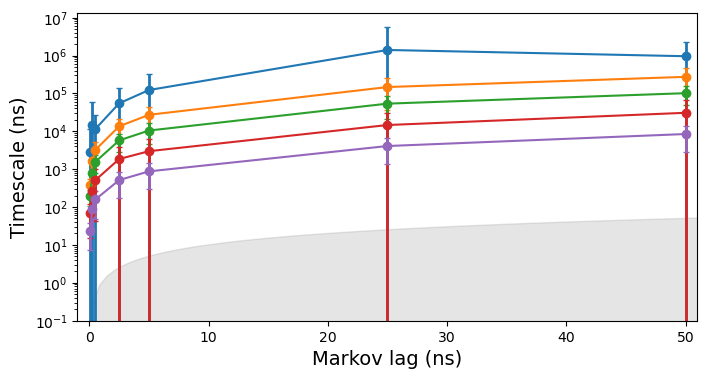

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(n_score):
    ax.errorbar(markov_lags, np.array(summary_groupby[f't{i+2}']['mean'].to_list())/20, 
                yerr=np.array(summary_groupby[f't{i+2}']['std'].to_list())/20, 
                marker='o', 
                label='t2',
                elinewidth=2, capsize=2, capthick=1)

ax.fill_between(np.linspace(-1, max(markov_lags)+10, 100), y1=np.linspace(-1,max(markov_lags)+10,100), color='gray', alpha=0.2)
ax.set_xlim([-1, max(markov_lags)+1])
ax.set_yscale('log')
ax.set_xlabel('Markov lag (ns)', fontsize=14)
ax.set_ylabel('Timescale (ns)', fontsize=14)

plt.savefig(save_dir / 'its.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()